In [1]:
#import libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense, Conv2D ,Flatten,Dropout,MaxPool2D, BatchNormalization
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory  
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import VGG19
import keras
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np 
import tensorflow as tf
import pandas as pd
import seaborn
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix , classification_report

In [2]:
#import our data
train_datagen = ImageDataGenerator(
    rescale=1. / 255,rotation_range=10, fill_mode='nearest',
     featurewise_center=True,
    featurewise_std_normalization=True,
    vertical_flip= True,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range = (0.4,0.6),
    horizontal_flip=True,validation_split=0.3)



In [3]:
train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/skincancer/Datasets/Train/',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',subset='training'
  )

Found 23189 images belonging to 2 classes.


In [4]:
test_generator = train_datagen.flow_from_directory(
     '/kaggle/input/skincancer/Datasets/Test/',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',subset='validation'
    
  )

Found 3294 images belonging to 2 classes.


Found 33126 files belonging to 2 classes.


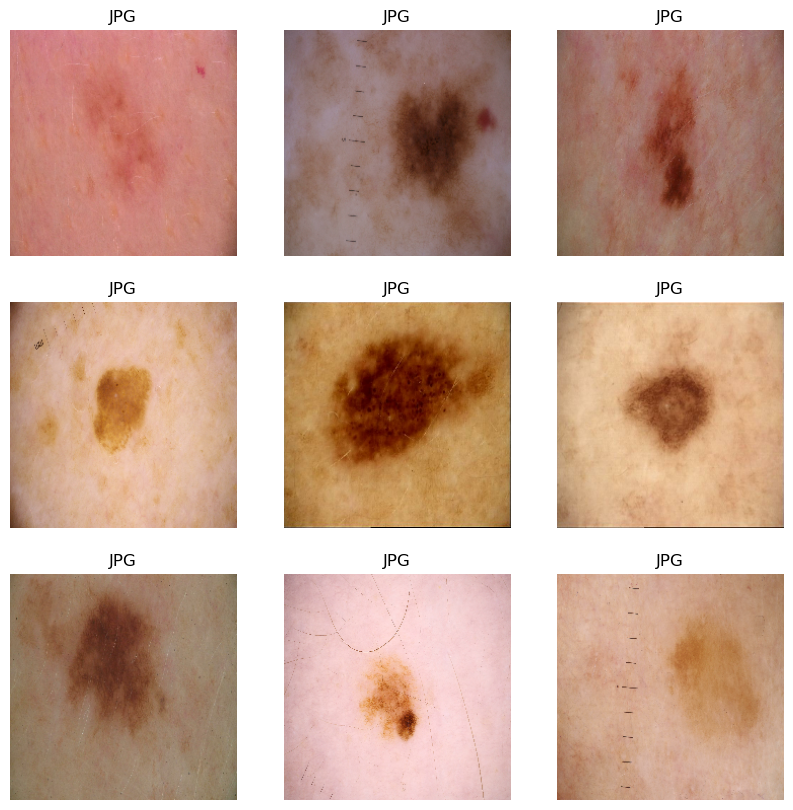

In [5]:
train_dataset = image_dataset_from_directory('/kaggle/input/skincancer/Datasets/Train/',
                                             shuffle=True,
                                             batch_size=32,image_size=(224,224))
class_name =  train_dataset.class_names
plt.figure(figsize = (10,10))
for image , label in train_dataset.take(1):
    for i in range(9) :
        plt.subplot(3,3,i+1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(class_name[label[i]])
        plt.axis("off")

In [6]:
#call vgg model
vgg_model =  VGG19(include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax")

for models in vgg_model.layers:
  models.trainable= False

574710816/574710816 [==============================] - 3s 0us/step


In [7]:
vgg_model = keras.Model(inputs=vgg_model.input, outputs=vgg_model.layers[-2].output)
model = keras.Sequential()
for layer in vgg_model.layers:
  model.add(layer)

model.add(Dense(2, activation='softmax'))

In [8]:
model.compile(optimizer="adam", loss=keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [9]:
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)

In [10]:
FIT =model.fit(train_generator,
    validation_data = test_generator, 
    callbacks = [early],
    epochs = 1)

725/725 [==============================] - 5055s 7s/step - loss: 8.0824e-04 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


In [11]:
model.evaluate(test_generator)

103/103 [==============================] - 499s 5s/step - loss: 0.0000e+00 - accuracy: 1.0000


[0.0, 1.0]

In [12]:
#classes names 
class_name = {0:"melanoma",1:"nevus" , 2 : 'seborrheic_keratosis'}


In [13]:
#predict test data
y = model.predict(test_generator)
y =  np.argmax(y,axis= 1 )
y 

103/103 [==============================] - 502s 5s/step


array([1, 1, 1, ..., 1, 1, 1])

In [14]:
#y_true and y_pred
y_true = np.array([])
y_pred = np.array([])

i = 0
for data, labels in test_generator:
  i += 1
  y = np.argmax(model.predict(data), axis=1)
  y_true = np.append(y_true, labels)
  y_pred = np.append(y_pred, y)
  
  if i == test_generator.samples // 32 + 1:
    break

1/1 [==============================] - 0s 192ms/step


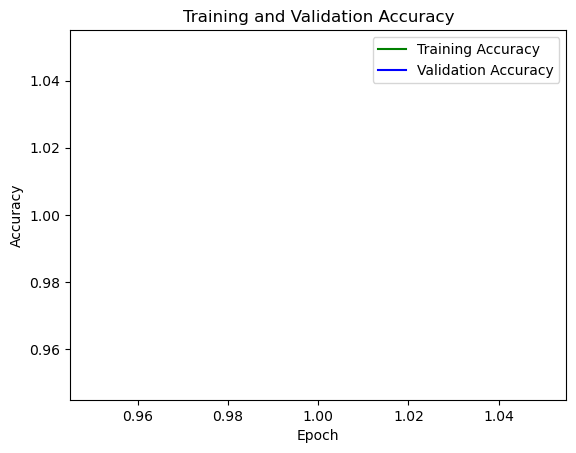

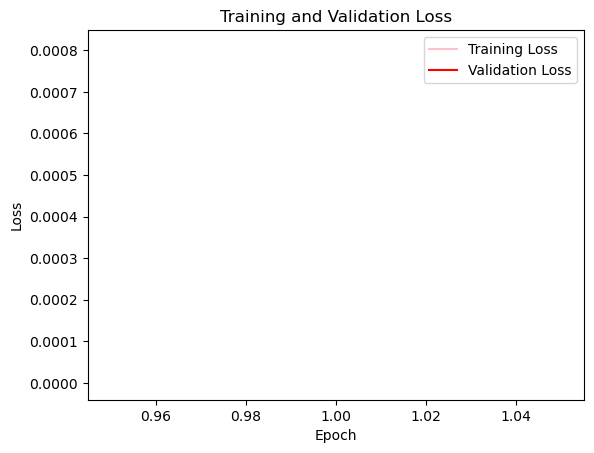

In [15]:
#plot the result
import matplotlib.pyplot as plt
acc = FIT.history['accuracy']
val_acc = FIT.history['val_accuracy']
loss = FIT.history['loss']
val_loss = FIT.history['val_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()
#loss plot
plt.plot(epochs, loss, color='pink', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [16]:
model.save('vggg19_model.h5')